Jacky Code

In [ ]:
#%pip install tensorflow pandas numpy
%pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Data processing

In [ ]:
import pandas as pd

metadata_path = "/content/drive/Shared drives/CSDS395_Senior_Project/archive/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)

df = df.loc[:, ~df.columns.duplicated()]
df["filename"] = df["image_id"] + ".jpg"

valid_labels = ['bkl', 'mel', 'vasc', 'nv', 'akiec']
df = df[df["dx"].isin(valid_labels)]
df["label"] = df["dx"]

df = df[["filename", "label"]]
df = df.dropna()
df.to_csv("/content/drive/Shared drives/CSDS395_Senior_Project/archive/processed_metadata.csv", index=False)


Training model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

data_dir_1 = "/content/drive/Shared drives/CSDS395_Senior_Project/archive/HAM10000_images_part_1"
data_dir_2 = "/content/drive/Shared drives/CSDS395_Senior_Project/archive/HAM10000_images_part_2"
metadata_path = "/content/drive/Shared drives/CSDS395_Senior_Project/archive/processed_metadata.csv"

df = pd.read_csv(metadata_path)
df["filename"] = df["filename"].astype(str)

batch_size = 16
img_size = (300, 300)
epochs = 10
num_classes = 5

data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

classes = ['bkl', 'mel', 'vasc', 'nv', 'akiec']

train_data = data_gen.flow_from_dataframe(
    dataframe=df,
    directory=data_dir_1,
    x_col="filename",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes,
    subset='training'
)

val_data = data_gen.flow_from_dataframe(
    dataframe=df,
    directory=data_dir_2,
    x_col="filename",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes,
    subset='validation'
)

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, validation_data=val_data, epochs=epochs)

model.save("/content/drive/Shared drives/CSDS395_Senior_Project/saved_model_5class.h5")


Mounted at /content/drive
Found 3743 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 4708 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 941 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 4678 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2733s 11s/step - accuracy: 0.8792 - loss: 0.3731 - val_accuracy: 0.0000e+00 - val_loss: 8.1523
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2414s 10s/step - accuracy: 0.9422 - loss: 0.1808 - val_accuracy: 0.0000e+00 - val_loss: 3.9033
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2437s 10s/step - accuracy: 0.9585 - loss: 0.1379 - val_accuracy: 0.0000e+00 - val_loss: 4.7132
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2448s 10s/step - accuracy: 0.9604 - loss: 0.1265 - val_accuracy: 0.0000e+00 - val_loss: 9.4843
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2450s 10s/step - accuracy: 0.9648 - loss: 0.1201 - val_accuracy: 0.0000e+00 - val_loss: 1415.7062
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2425s 10s/step - accuracy: 0.9716 - loss: 0.0967 - val_accuracy: 0.0000e+00 - val_loss: 30.2514
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2455s 10s/step - accuracy: 0.9675 - loss: 0.0994 - val_accuracy: 0.0000e+00 - val_loss: 4.3569
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2509s 11s/s

In [ ]:
label_counts = df["label"].value_counts()
print(label_counts)


label
nv       6705
mel      1113
bkl      1099
akiec     327
vasc      142
Name: count, dtype: int64


Arjun Code

In [ ]:
import pandas as pd
import os

# Define paths relative to where the notebook is (ai_model/)
IMG_DIR = "../data/HAM10000_images_part_1"  # Corrected path to images
CSV_PATH = "../data/HAM10000_metadata.csv"  # Corrected path to metadata CSV

# Load the metadata file
df = pd.read_csv(CSV_PATH)

# Add the full file paths to the DataFrame
df["full_path"] = df["image_id"].apply(lambda x: os.path.join(IMG_DIR, x + ".jpg"))

# Remove rows where the image file does not exist
df = df[df["full_path"].apply(os.path.exists)]

# Save the processed metadata for debugging (optional)
df.to_csv("../data/processed_metadata.csv", index=False)

# Check the first few rows to verify file paths
print(df.head())



      lesion_id      image_id   dx dx_type   age   sex     localization  \
2   HAM_0002730  ISIC_0026769  bkl   histo  80.0  male            scalp   
3   HAM_0002730  ISIC_0025661  bkl   histo  80.0  male            scalp   
22  HAM_0003301  ISIC_0027310  bkl   histo  60.0  male             back   
24  HAM_0004884  ISIC_0025937  bkl   histo  75.0  male  upper extremity   
43  HAM_0007409  ISIC_0025076  bkl   histo  50.0  male  upper extremity   

                                          full_path  
2   ../data/HAM10000_images_part_1/ISIC_0026769.jpg  
3   ../data/HAM10000_images_part_1/ISIC_0025661.jpg  
22  ../data/HAM10000_images_part_1/ISIC_0027310.jpg  
24  ../data/HAM10000_images_part_1/ISIC_0025937.jpg  
43  ../data/HAM10000_images_part_1/ISIC_0025076.jpg  


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data generator
train_data = data_gen.flow_from_dataframe(
    dataframe=df,
    directory=None,  # Use None because full paths are provided
    x_col="full_path",  # Column with full image paths
    y_col="dx",  # Ensure this matches your label column name
    target_size=(224, 224),
    batch_size=16,
    subset="training",
    class_mode="categorical"
)

# Validation data generator
val_data = data_gen.flow_from_dataframe(
    dataframe=df,
    directory=None,  # Use None because full paths are provided
    x_col="full_path",
    y_col="dx",
    target_size=(224, 224),
    batch_size=16,
    subset="validation",
    class_mode="categorical"
)



Found 810 validated image filenames belonging to 7 classes.
Found 202 validated image filenames belonging to 7 classes.


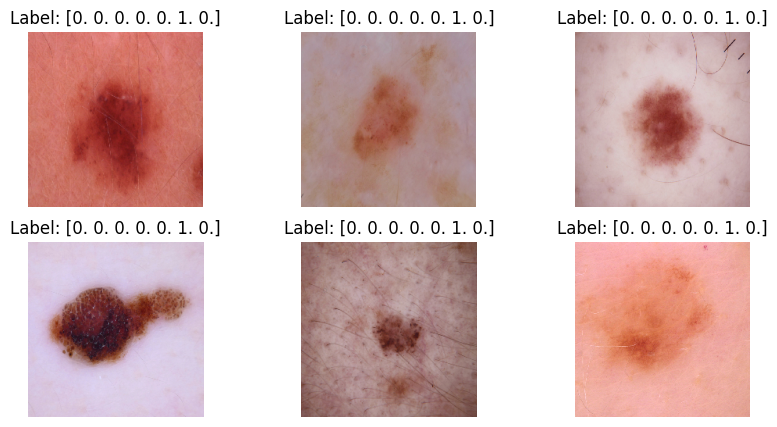

In [ ]:
import matplotlib.pyplot as plt
batch = next(iter(train_data))  # Get a batch of images

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(batch[0][i])  # Display the image
    plt.title(f"Label: {batch[1][i]}")
    plt.axis("off")
plt.show()


In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load base model
base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(len(df["dx"].unique()), activation="softmax")(x)  # Output layer

# Define the complete model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(train_data, validation_data=val_data, epochs=10)

# Save the trained model to the ai_model folder
model.save("skin_model.h5")



Epoch 1/10


KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import load_model


model = load_model("skin_model.h5")




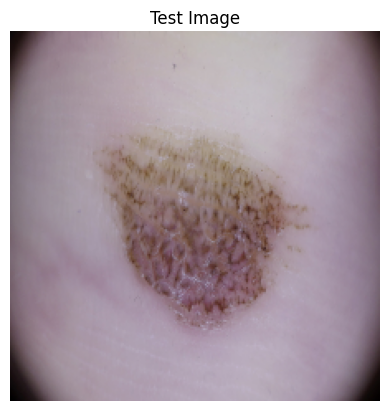

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the image path (place your test image in 'data/' folder)
TEST_IMAGE_PATH = "../data/HAM10000_images_part_1/ISIC_0024340.jpg"

# Load and preprocess the image
img = cv2.imread(TEST_IMAGE_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img = cv2.resize(img, (224, 224))  # Resize to match model input size
img = img / 255.0  # Normalize pixel values
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Display the image
plt.imshow(img[0])
plt.title("Test Image")
plt.axis("off")
plt.show()


In [ ]:

predictions = model.predict(img)

# Show prediction confidence scores
print("Raw model output:", predictions)

# Get the class with highest probability
predicted_class = np.argmax(predictions)
class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


# Print predicted class
print(f"Predicted class: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Raw model output: [[0.02056903 0.00939138 0.01194326 0.00151235 0.00163162 0.9326165
  0.02233598]]
Predicted class: nv


In [ ]:
# Check model output shape
print("Model output shape:", model.output_shape)

# Print raw prediction values
print("Raw model output:", predictions)

# Get the predicted index
predicted_class = np.argmax(predictions)
print("Predicted index:", predicted_class)

# Print class labels length
print("Number of classes in class_labels:", len(class_labels))



Model output shape: (None, 7)
Raw model output: [[0.02056903 0.00939138 0.01194326 0.00151235 0.00163162 0.9326165
  0.02233598]]
Predicted index: 5
Number of classes in class_labels: 7
